In [1]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")

generate_entangled_mps (generic function with 1 method)

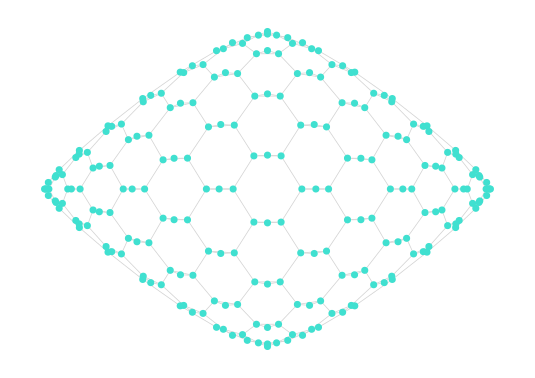

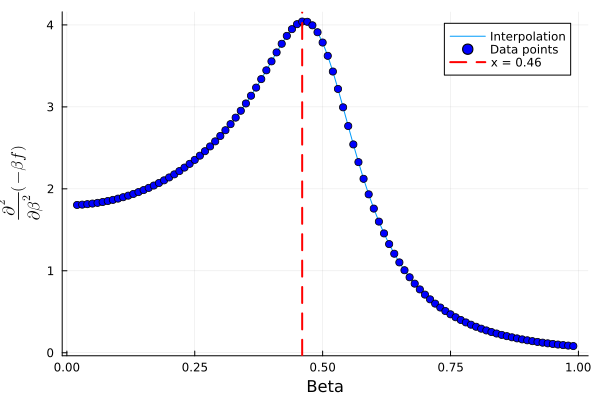

In [6]:
function Trivertex_classical_ising_partition_function(Nx::Int, Ny::Int, beta, plotting=false)
    
    """ 
    Function which creates a ferromagnetic (j=1) classical ising model partition function on a square grid.
    Takes in the sizes of the IsingModel Nx, Ny and β.
    Function returns a Tenet TensorNetwork
    """

    # boltzman matrix
    B = [exp(beta) exp(-beta); exp(-beta) exp(beta)]
    sqrtB = convert(Matrix{Float64}, B^(1/2)) ### USE THE CONVERT BECAUSE JULIA HAS ALL THE TYPES OF OBJECTS? -> works
    # sqrtB = B^(1/2) # -> doesn't work -> Symetric? 

    # creating the building blocks of the ising tensor network
    # getting to know einsum notation in Jutho's tensor operations

    # Generating the relevant data arrays -> A2 = corner Tensor, A3 = edge Tensor, A4 = bulk Tensor
    @tensor begin
        A2[i,j] := sqrtB[i,k]*sqrtB[k,j] #contraction along k
        
        ### JULIA HAS INDICES STARTING AT ONE !!!!!!!!!!!!!!!!!!!!!!! STOP FORGETTING
        A3[i,j,k] := sqrtB[:,1][i]*sqrtB[:,1][j]*sqrtB[:,1][k] + sqrtB[:,2][i]*sqrtB[:,2][j]*sqrtB[:,2][k] #is this the easiest way to do an outer product?
        A4[i,j,k,l] := sqrtB[:,1][i]*sqrtB[:,1][j]*sqrtB[:,1][k]*sqrtB[:,1][l] + sqrtB[:,2][i]*sqrtB[:,2][j]*sqrtB[:,2][k]*sqrtB[:,2][l]

    end 


    tensors = []

    ## the layout structure --> Use the Graphs.jl package for underlying functionality... Don't code it all yourself

    n_tensors = Nx*Ny
    n_edges = 2*Nx*Ny - Nx - Ny
    G = Graphs.grid([Nx,Ny])
    nvertices = nv(G) # number of vertices
    nedges = ne(G)    # number of edges

    nodes = [node for node in vertices(G)]
    nodes_labels = [[i,j] for i in 1:Nx for j in 1:Ny]
    nodes_map = Dict(zip(nodes, nodes_labels)) # Create a mapping dict
    edgesgraph = [edge for edge in edges(G)]
    edges_labels = [Symbol(edge) for edge in 1:nedges]
    edges_map = Dict(zip(edgesgraph, edges_labels))

    if plotting == true
        display(gplot(G, nodelabel=nodes, edgelabel=1:n_edges, layout=spectral_layout))
    end


    
    # Generating the tensors inside of the network
    for source in vertices(G)
        inds = Tuple([edges_map[edge] for edge in edges(G) if source in([src(edge), dst(edge)])])
        if length(inds) == 2
            push!(tensors, Tensor(A2, inds))
        end
        if length(inds) == 3
            push!(tensors, Tensor(A3, inds))
        end
        if length(inds) == 4
            push!(tensors, Tensor(A4, inds))
        end   
        
    end

    ising_network = TensorNetwork(tensors)
    #println(length(Tenet.tensors(ising_network)))
    for tensor in Tenet.tensors(ising_network)
        rank = length(inds(tensor))
        if rank > 3 #remove the bulk tesnors and replace them with new SVD-ed tensors
            pop!(ising_network, tensor)
            U,S,V = LinearAlgebra.svd(tensor, left_inds=inds(tensor)[1:2])
            push!(ising_network, U)
            push!(ising_network, S)
            push!(ising_network, V)
        end
    end

    return ising_network

    # Generate a TensorNetwork based on all the tensors in the list of tensors
    # Return this as a Tenet tensor network object
end



Nx = 10
Ny = 10

ising_classical2dTN = Trivertex_classical_ising_partition_function(Nx, Ny, 0.44, false)
# transform to trivertex - structure


g, tensor_vertex_map, index_edge_map, fully_weighted_edge_list, edge_index_map = extract_graph_representation(ising_classical2dTN)
display(gplot(g, layout=spectral_layout))



drawing1 = Makie.plot(ising_classical2dTN, node_color=[:darkred for i in 1:length(tensors(ising_classical2dTN))], labels=true, layout=Stress(), edge_color=:grey80)

display(drawing1)

## check that the ising has properties that we are looking for
function compute_second_derivative(arr, h=beta_list[2] - beta_list[1])
    """
    Compute the discrete second derivative of an array using central differences.

    Parameters:
    - arr: 1D array
        Input array.
    - h: float, optional
        Step size for central differences. Default is the difference between the second and first elements of beta_list.

    Returns:
    - second_derivative: 1D array
        Array containing the computed second derivatives.
    """
    n = length(arr)
    second_derivative = zeros(n)

    for i in 2:n-1
        second_derivative[i] = (arr[i+1] - 2*arr[i] + arr[i-1]) / h^2
    end

    return second_derivative
end


beta_list = [0.01*i for i in 1:100]
ising_model_result_list = []

for beta_active in beta_list
    tn_active = TN2D_classical_ising_partition_function(Nx, Ny, beta_active)
    push!(ising_model_result_list, log(Tenet.contract(tn_active)[1])/(length(tensors(tn_active))))
end


result_2nd_diff = compute_second_derivative(ising_model_result_list)
latex_expression = "\$\\frac{\\partial^2}{\\partial\\beta^2}\\left(-\\beta f\\right)\$"





plot_data = Plots.plot(beta_list[2:end-1], result_2nd_diff[2:end-1], label="Interpolation") #broadcast in onto the relative erorrs instead of calling the function
Plots.plot!(plot_data, beta_list[2:end-1], result_2nd_diff[2:end-1], seriestype=:scatter, label="Data points", color="blue")
Plots.xlabel!(plot_data,  "Beta")
Plots.ylabel!(plot_data, latex_expression)
vline!(plot_data, [0.46], linestyle=:dash, linewidth=2, color="red", label="x = 0.46")

# Display the plot
display(plot_data)








